# 0. Importing Libraries & Dataset

In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import pandas as pd
import numpy as np

!pip install tensorflow-addons
import tensorflow_addons as tfa
import os

from sklearn.model_selection import train_test_split

# Tensorflow version 2.12.0
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2.12.0


In [2]:
# Mount drive to notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Directory verification
# !ls /content/drive/'My Drive'/RMIT/COSC2793_ML
# !ls /content/drive/'MyDrive'/'COSC2673'

In [4]:
locationMain = "/content/drive/MyDrive/COSC2673/Image_classification_data/data_labels_mainData.csv"
locationExtra = "/content/drive/MyDrive/COSC2673/Image_classification_data/data_labels_extraData.csv"
dfMain = pd.read_csv(locationMain)
dfExtra = pd.read_csv(locationExtra)

In [5]:
# Change the labels from integer to string type
dfMain['isCancerous'] = dfMain['isCancerous'].astype(str)
dfExtra['isCancerous'] = dfExtra['isCancerous'].astype(str)
dfMain['cellType'] = dfMain['cellType'].astype(str)

In [6]:
# Get datasets based on the class labels for cancer
cancerous = dfMain[dfMain.isCancerous == '1']
benign = dfMain[dfMain.isCancerous == '0']
cancerous.shape

(4079, 6)

In [7]:
# Load images from zip file
! cp /content/drive/'MyDrive'/'COSC2673'/Image_classification_data/patch_images.zip .
! unzip -q -o patch_images.zip
# ! rm patch

In [8]:
# Function to do a 60/20/20 split
def train_val_test_split(df, state):
  # Get 20% out from dataset as test dataset
  train_val_df,test_df = train_test_split(df,
                                          test_size=0.2,
                                          shuffle=True,
                                          random_state=state)
  # Get 25% from the remaining data after removing the test dataset
  # To get 20% of validation data from overall dataset
  train_df, val_df = train_test_split(train_val_df,
                                      test_size=0.25,
                                      shuffle = True,
                                      random_state = state)
  return train_df,val_df,test_df

In [9]:
# Split dataset into training, testing and validation
state = 1212125
train_df, val_df, test_df = train_val_test_split(dfMain,state)
# train_val_df,test_df = train_test_split(dfMain,test_size=0.2,shuffle=True,random_state=state)
# train_df, val_df = train_test_split(train_val_df, test_size=0.25, shuffle = True, random_state = state)

In [10]:
# Verify the shape of dataset
print("Shape of Training dataset:",train_df.shape)
print("Shape of Validation dataset:", val_df.shape)
print("Shape of testing dataset:", test_df.shape)

Shape of Training dataset: (5937, 6)
Shape of Validation dataset: (1979, 6)
Shape of testing dataset: (1980, 6)


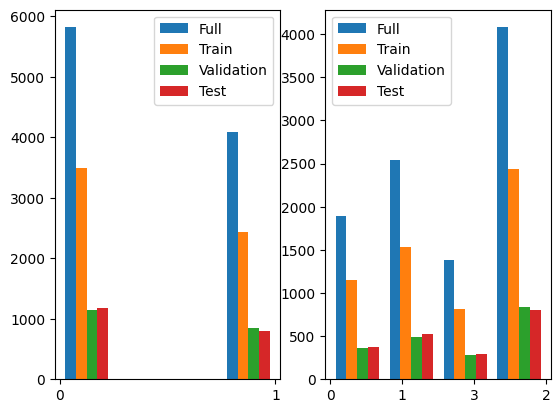

In [11]:
for i,col in enumerate(dfMain[['isCancerous','cellType']]):
  plt.subplot(1,2,i+1)
  plt.hist((dfMain[col],train_df[col],val_df[col],test_df[col])
  ,4,
  label=('Full','Train','Validation','Test'))
  plt.legend()

# Utilities

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Function to create normalized image data generator
def image_data_generator(df, xcolName, ycolName, batch_size):
  # Rescale from 0-255 to 0-1
    datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
    data_generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory='patch_images/',
        x_col=xcolName,
        y_col=ycolName,
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')
    return data_generator

In [13]:
ROOT = "/content/drive/My Drive/RMIT/COSC2793_ML/"

# Function to save checkpoints when training a model into their respective directory
# Save checkpoint every 10 epochs
def get_callback(model_folder,save_epochs):
    checkpoint_path = ROOT + model_folder + "/checkpoints/ckp-{epoch:04d}.ckpt"
    # checkpoint_dir = os.path.dirname(checkpoint_path)
    
    ckp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    verbose=1,
    # Save weights only
    save_weights_only=True,
    # save_freq = save_epochs * batch_size,
    save_freq = 'epoch',
    period = save_epochs
    )
    return ckp_callback

In [14]:
# Function to train model
def train_model(model, modelName, train_gen, val_gen):
  # Get directory to saving the checkpoints
  checkpoint_path = ROOT + modelName + "/checkpoints/ckp-{epoch:04d}.ckpt"
  model.save_weights(checkpoint_path.format(epoch=0))

  # Fit the model to the train and validation data generator
  history = model.fit_generator(train_gen,
                                validation_data = val_gen,
                                epochs=150,
                                callbacks = [get_callback(modelName,10)],
                                verbose=0)
  # Save model
  model.save(ROOT+modelName)
  print("Model generated at ", ROOT+modelName)
  return history

In [15]:
# Function to evaluate model that has been trained and saved
def savedModel_evaluate(model, train_gen, test_gen):
    print("Model's performance on Trainining Dataset:")
    model.evaluate(train_gen)
    print("\nModel's performance on Testing Dataset:")
    model.evaluate(test_gen)

In [16]:
# Load saved model in directory and get evaluate it's performance
def load_savedModel(modelName, train_gen, val_gen):
  model = tf.keras.models.load_model(ROOT+modelName)
  # if (model):
  print('Existing model found')
  savedModel_evaluate(model,train_gen,val_gen)
  return model

In [17]:
# Function to print the loss and score of the model over the epochs
def model_stats(history, loss, metric):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(history.history[loss], 'r--')
    plt.plot(history.history['val_'+loss], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history[metric], 'r--')
    plt.plot(history.history['val_'+metric], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'val'], loc='upper left')

# Model 1. Basic Multilayer Perceptron for Binary Classification (isCancerous)

**Data Preprocessing**
1. Normalized image data

**Model**
1.   1 Hidden Layer | 256 Nodes | Sigmoid Activation Function
2. SGD Optimizer
3. Loss: Binary Cross Entropy
4. Metrics: F1 Score, Precision, Recall




In [18]:
# 27 x 27 with 3 channels
INPUT_DIM = (27,27,3)
# Number of nodes in the hidden layer
HIDDEN_LAYER_DIM = 256
# Number of class to be predicted
OUTPUT_CLASSES = 2

In [19]:
# Using Sequential API to build the model as shown in the tutorial
# import tensorflow as tf

model = tf.keras.Sequential([
    # Layer 1: Transform the image into correct format
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    # Layer 2: 256 nodes
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    # Layer 3: Work together with Layer 2 to produce 2 outputs
    # To determine the class of the image
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________
None


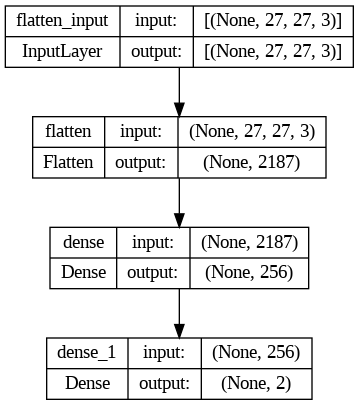

In [20]:
# Get information about the model structure
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
# Compile the model
# SGD as optimizer
# Binary Crossentropy as loss
# Precision, Recall, F1 Score as metrics
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES)])

In [22]:
# Generate train, validation and test data generator with batch size of 32
batch_size = 32
train_generator = image_data_generator(train_df, "ImageName","isCancerous",batch_size)
validation_generator = image_data_generator(val_df, "ImageName","isCancerous",batch_size)
test_generator = image_data_generator(test_df, "ImageName","isCancerous",batch_size)
test_generator_extra = image_data_generator(dfExtra, "ImageName","isCancerous",batch_size)

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.
Found 10384 validated image filenames belonging to 2 classes.


In [23]:
# Combine 2 datasets for training, remove columns relating to cell types
dfMain_nocell = dfMain.loc[:, ~dfMain.columns.isin(['cellType','cellTypeName'])]
dfAll = pd.concat([dfMain_nocell, dfExtra])
dfAll['isCancerous'] = dfAll['isCancerous'].astype(str)
dfAll

,InstanceID,patientID,ImageName,isCancerous
0,22405,1,22405.png,0
1,22406,1,22406.png,0
2,22407,1,22407.png,0
3,22408,1,22408.png,0
4,22409,1,22409.png,0
...,...,...,...,...
10379,20028,99,20028.png,0
10380,20029,99,20029.png,0
10381,20030,99,20030.png,0
10382,20031,99,20031.png,0


In [24]:
# Check if there are any duplicated data
dfAll.duplicated().any()

False

In [25]:
state = 1212125
train_dfAll, val_dfAll, test_dfAll = train_val_test_split(dfAll,state)
# train_val_dfAll,test_dfAll = train_test_split(dfAll,test_size=0.2,shuffle=True,random_state=state)

# train_dfAll, val_dfAll = train_test_split(train_val_dfAll, test_size=0.25, shuffle = True, random_state = state)

In [26]:
# Modify Train image generator to perform image data augmentation
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range = 15,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             data_format='channels_last')

train_generatorAll = datagen.flow_from_dataframe(
    dataframe=train_dfAll,
    directory='patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

# Use default image data generator for validation and test set
val_generatorAll = image_data_generator(val_dfAll,'ImageName','isCancerous',batch_size)
test_generatorAll = image_data_generator(test_dfAll,'ImageName','isCancerous',batch_size)

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [27]:
# https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1

In [28]:
# Train basic model
training_model = False
try:
  model_gs2l = tf.keras.models.load_model(ROOT+'gscale_2layer')
except:
  training_model = True
  history = train_model(model,"gscale_2layer",train_generator,validation_generator)

In [29]:
if training_model:
  model_stats(history,'loss','precision')

In [30]:
# model_gs2l_dir = 'gscale_2layer/'
# model_gs2l_weights = tf.train.latest_checkpoint(root_folder+model_gs2l_dir)
# if not training_model:
#   model_gs2l = tf.keras.models.load_model(ROOT+'gscale_2layer')

In [31]:
# if not training_model:
model = load_savedModel('gscale_2layer',train_generator,test_generator)

Existing model found
Model's performance on Trainining Dataset:
186/186 [==============================] - 6s 26ms/step - loss: 0.2735 - precision: 0.9172 - recall: 0.8381 - f1_score: 0.8817

Model's performance on Testing Dataset:
62/62 [==============================] - 3s 46ms/step - loss: 0.3145 - precision: 0.8967 - recall: 0.8197 - f1_score: 0.8636


In [32]:
load_savedModel('gscale_2layer',test_generator,test_generatorAll)

Existing model found
Model's performance on Trainining Dataset:
62/62 [==============================] - 3s 32ms/step - loss: 0.3145 - precision: 0.8967 - recall: 0.8197 - f1_score: 0.8636

Model's performance on Testing Dataset:
127/127 [==============================] - 4s 31ms/step - loss: 0.5080 - precision: 0.8071 - recall: 0.7271 - f1_score: 0.7766


Being being very basic, the model did really well with nearly 90% training f1 score and just a 2% drop when classifying new data. However, when predicting on the joined dataset, there is a significant deccrease across all metrics! This signifies that overfitting may have occured. Thus, different techniques that helps with overfitting will be explored.

# Model 2: Combining 2 datasets & using Data Augmentation
**Data Preprocessing**
1. Normalized image data
2. Image Data Augmentation

**Model**
1.   1 Hidden Layer | 256 Nodes | Sigmoid Activation Function
2. SGD Optimizer
3. Loss: Binary Cross Entropy
4. Metrics: F1 Score, Precision, Recall


In [33]:
model_aug = tf.keras.Sequential([
    # Layer 1: Transform the image into correct format
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    # Layer 2: 256 nodes
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    # Layer 3: Work together with Layer 2 to produce 2 outputs
    # To determine the class of the image
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model_aug.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES)])

In [34]:
training_model = False
try:
  model_aug = load_savedModel('augmented',train_generatorAll,test_generatorAll)
except:
  training_model = True
  history_aug = train_model(model_aug,"augmented",train_generatorAll,val_generatorAll)

Existing model found
Model's performance on Trainining Dataset:
381/381 [==============================] - 15s 38ms/step - loss: 0.4656 - precision_2: 0.8222 - recall_2: 0.6480 - f1_score: 0.7355

Model's performance on Testing Dataset:
127/127 [==============================] - 2s 15ms/step - loss: 0.4327 - precision_2: 0.8460 - recall_2: 0.6785 - f1_score: 0.7516


In [35]:
# print(history.history.keys())
if training_model:
  model_stats(history_aug,'loss','precision_2')

In [36]:
if not training_model:
  model_aug = load_savedModel('augmented',train_generatorAll,test_generatorAll)

Existing model found
Model's performance on Trainining Dataset:
381/381 [==============================] - 15s 38ms/step - loss: 0.4651 - precision_2: 0.8262 - recall_2: 0.6466 - f1_score: 0.7357

Model's performance on Testing Dataset:
127/127 [==============================] - 3s 22ms/step - loss: 0.4327 - precision_2: 0.8460 - recall_2: 0.6785 - f1_score: 0.7516


It is surprising to see how much the performance of the model dropped when using image data augmentation. However, it is a fact that the dataset is imbalanced. Thus, data augmentation will be kept and different other features will be experimented

# Model 2.5 Data Augmentation + GrayScale

In [37]:
def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

In [38]:
# Modify Train image generator to perform image data augmentation
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255,
                             preprocessing_function = to_grayscale,
                             data_format='channels_last')

train_generatorBL = datagen.flow_from_dataframe(
    dataframe=train_dfAll,
    directory='patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

# Use default image data generator for validation and test set
# val_generatorBL = image_data_generator(val_dfAll,'ImageName','isCancerous',batch_size)
# test_generatorBL = image_data_generator(test_dfAll,'ImageName','isCancerous',batch_size)

Found 12168 validated image filenames belonging to 2 classes.


In [39]:
model_augBl = tf.keras.Sequential([
    # Layer 1: Transform the image into correct format
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    # Layer 2: 256 nodes
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    # Layer 3: Work together with Layer 2 to produce 2 outputs
    # To determine the class of the image
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model_augBl.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES)])

In [40]:
training_model = False
try:
  model_augBl = load_savedModel('augmented_BL',train_generatorBL,test_generatorAll)
except:
  training_model = True
  history_augBl = train_model(model_augBl,"augmented_BL",train_generatorBL,val_generatorAll)

Existing model found
Model's performance on Trainining Dataset:
381/381 [==============================] - 27s 70ms/step - loss: 0.3879 - precision_2: 0.8701 - recall_2: 0.7372 - f1_score: 0.8122

Model's performance on Testing Dataset:
127/127 [==============================] - 2s 16ms/step - loss: 0.4405 - precision_2: 0.8434 - recall_2: 0.7088 - f1_score: 0.7777


In [41]:
# print(history.history.keys())
if training_model:
  model_stats(history_augBl,'loss','precision_2')

In [42]:
model_augBl = load_savedModel('augmented_BL',train_generatorBL,test_generatorAll)

Existing model found
Model's performance on Trainining Dataset:
381/381 [==============================] - 29s 74ms/step - loss: 0.3879 - precision_2: 0.8701 - recall_2: 0.7372 - f1_score: 0.8122

Model's performance on Testing Dataset:
127/127 [==============================] - 2s 16ms/step - loss: 0.4405 - precision_2: 0.8434 - recall_2: 0.7088 - f1_score: 0.7777


# Model 3: Data Augmentation with L2 Regularization
**Data Preprocessing**
1. Normalized image data
2. Image Data Augmentation

**Model**
1.   1 Hidden Layer | 256 Nodes | Sigmoid Activation Function | L2 regularizer
2. SGD Optimizer
3. Loss: Binary Cross Entropy
4. Metrics: F1 Score, Precision, Recall

In [43]:
reg_lambda = 0.01
model_l2 = tf.keras.Sequential([
    # Layer 1: Transform the image into correct format
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    # Layer 2: 256 nodes
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, 
                          activation='sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # Layer 3: Work together with Layer 2 to produce 2 outputs
    # To determine the class of the image
    tf.keras.layers.Dense(OUTPUT_CLASSES,
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [44]:
model_l2.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES)])

In [45]:
training_model = False
try:
  model_l2 = load_savedModel('normalize_l2',train_generatorAll,test_generatorAll)
except:
  training_model = True
  history_l2 = train_model(model_l2,"normalize_l2",train_generatorAll,val_generatorAll)

Existing model found
Model's performance on Trainining Dataset:
381/381 [==============================] - 23s 60ms/step - loss: 0.5782 - precision_3: 0.8103 - recall_3: 0.5809 - f1_score: 0.6616

Model's performance on Testing Dataset:
127/127 [==============================] - 7s 57ms/step - loss: 0.5586 - precision_3: 0.8157 - recall_3: 0.6132 - f1_score: 0.6645


In [46]:
# print(history_l2.history.keys())
if training_model:
  model_stats(history_l2,'loss','precision_3')

In [47]:
# if not training_model:
model_l2 = load_savedModel('normalize_l2',train_generatorAll,test_generatorAll)

Existing model found
Model's performance on Trainining Dataset:
381/381 [==============================] - 15s 38ms/step - loss: 0.5795 - precision_3: 0.8115 - recall_3: 0.5790 - f1_score: 0.6605

Model's performance on Testing Dataset:
127/127 [==============================] - 3s 23ms/step - loss: 0.5586 - precision_3: 0.8157 - recall_3: 0.6132 - f1_score: 0.6645


# Model 4: Data Augmentation + L2 Regularization + Drop out
**Data Preprocessing**
1. Normalized image data
2. Image Data Augmentation

**Model**
1.   Hidden Layer 1 | 256 Nodes | Sigmoid Activation Function | L2 regularizer
2. Hidden Layer 2 | Dropout layer
2. SGD Optimizer
3. Loss: Binary Cross Entropy
4. Metrics: F1 Score, Precision, Recall

In [48]:
reg_lambda = 0.01
model_l2drp = tf.keras.Sequential([
    # Layer 1: Transform the image into correct format
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    # Layer 2: 256 nodes
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, 
                          activation='sigmoid',
                          ),
    # Dropout Layer
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [49]:
model_l2drp.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES)])

In [50]:
training_model = False
try:
  model_l2drp = load_savedModel('normalize_dropout',train_generatorAll,test_generatorAll)
except:
  training_model = True
  history_l2drp = train_model(model_l2drp,"normalize_dropout",train_generatorAll,val_generatorAll)

Existing model found
Model's performance on Trainining Dataset:
381/381 [==============================] - 15s 37ms/step - loss: 0.4762 - precision_4: 0.8240 - recall_4: 0.6301 - f1_score: 0.7331

Model's performance on Testing Dataset:
127/127 [==============================] - 2s 16ms/step - loss: 0.4327 - precision_4: 0.8515 - recall_4: 0.6699 - f1_score: 0.7566


In [51]:
if training_model:
  model_stats(history_l2drp,'loss','precision_4')

In [52]:
model_l2drp = load_savedModel('normalize_dropout',train_generatorAll,test_generatorAll)

Existing model found
Model's performance on Trainining Dataset:
381/381 [==============================] - 16s 40ms/step - loss: 0.4749 - precision_4: 0.8244 - recall_4: 0.6290 - f1_score: 0.7332

Model's performance on Testing Dataset:
127/127 [==============================] - 2s 17ms/step - loss: 0.4327 - precision_4: 0.8515 - recall_4: 0.6699 - f1_score: 0.7566
